# Crop Type Classification Using Remote Sensing Time-Series

## Part - I - Data Processing & EDA Analysis

#### Author: Khizer Zakir

A litte outline for this notebook:

- **Section-1:**

    In this section, we first provide a brief overview about the dataset. After, we preprocess the dataset to identify the primary characteristics of the data, such as:

    - `shape and size of the data`
    - `missing values`
    - `data distribution`
    - `explanatory and target variables`

    Using these information, we will try to prepare the data for further analysis. In the end of this section, we prepare the dataset with desired attributes for further analysis. 

- **Section-2:**

    In the next section, we are using the pre-processed data acquired from the previous section, to normalize the data using two methods:
    
    i. Using $2^{nd}$ and $98^{th}$ percentile as `min` and `max`
    
    ii. Only using $98^{th}$ percentile as `max` to normalize the band value distribution. 

    Following that, we are going to plot band profiles and NDVI profiles for each class. 

    Later, we will just export the normalized data that will be used with the planned "Machine Learning and Deep Learning" algorithms. 


In [1]:
# load libraries

import warnings
warnings.filterwarnings("ignore")

# for data processing

import os
import numpy as np
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import joblib
from textwrap import dedent
import time
from tqdm import tqdm
import json

# custom module to make data frequency viz

from class_frequency import classFrequency

# Section:1 

## Dataset Information

Each observation in the dataset consists of a time series of 62 observations taken across 10 spectral bands of Sentinel-2 for 19 different classes in France. Each observation corresponds to spectral measurements aggregated over a land parcel. The observations are labeled with the crop found in the parcel.

## Reference Papers

- [Nyborg, J., Pelletier, C., Lefèvre, S., & Assent, I. (2022). TimeMatch: Unsupervised cross-region adaptation by temporal shift estimation. ISPRS Journal of Photogrammetry and Remote Sensing, 188, 301-313.](https://arxiv.org/abs/2111.02682)
- [Painblanc, F., Chapel, L., Courty, N., Friguet, C., Pelletier, C., & Tavenard, R. (2023, September). Match And Deform: Time Series Domain Adaptation through Optimal Transport and Temporal Alignment. In Joint European Conference on Machine Learning and Knowledge Discovery in Databases (pp. 341-356). Cham: Springer Nature Switzerland.](https://arxiv.org/abs/2308.12686)

## Repository References

- [TimeMatch](https://github.com/jnyborg/timematch)
- [Match And Deform (MAD)](https://github.com/rtavenar/MatchAndDeform)

## Dataset Source

The dataset used in this demonstration can be found at: [Dataset Source](https://doi.org/10.5281/zenodo.5636422)


In [2]:
# the main path

main_path = r"C:\Users\Khizer Zakir\OneDrive - Université Bretagne Sud\thesis\Covariance_Thesis\notebooks\npz_data_preprocessed\data_CDE"

# data

data_path = os.path.join(main_path, "data_FR1.npz")


In [3]:
# Data loading

data = np.load(data_path, allow_pickle= True)
series = data['series'] # time series (m,l,b)
labels = data['labels'] 
dates = data['dates'] # acquisition dates (datetime package)
class_names = data['class_names'] # names of the class
data.close()


In [4]:
# shape and type of the dataset

print(dedent(f'''
Dataset shapes and types:
    series: {series.shape,type(series)}
    labels: {labels.shape,type(labels)}
    dates: {dates.shape,type(dates)}
    class:{class_names.shape,type(class_names)}
    unique classes: {np.unique(labels)}
'''))

# B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12' these are 10 bands used as 10 features in this dataset


Dataset shapes and types:
    series: ((115755, 62, 10), <class 'numpy.ndarray'>)
    labels: ((115755,), <class 'numpy.ndarray'>)
    dates: ((62,), <class 'numpy.ndarray'>)
    class:((19,), <class 'numpy.ndarray'>)
    unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]



In [5]:
# descriptive stats

#reshape dataset 

series_2d = series.reshape(115755, 10*62)

# Setting Pandas to show every row and columns at visualizations

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [6]:
#Create list of columns names

cols = ['B02', 'B03', 'B04', 'B08', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']
rep_cols = [f'{col}_{(i-1)//10 + 1}' for i, col in enumerate(cols * 62, start=1)]

df = pd.DataFrame(series_2d, columns=rep_cols)

#Setting format to not show values in exponential format

pd.set_option('display.float_format', '{:.2f}'.format)

#Descriptive statistics of the datasets
df.describe()

,B02_1,B03_1,B04_1,B08_1,B05_1,B06_1,B07_1,B8A_1,B11_1,B12_1,B02_2,B03_2,B04_2,B08_2,B05_2,B06_2,B07_2,B8A_2,B11_2,B12_2,B02_3,B03_3,B04_3,B08_3,B05_3,B06_3,B07_3,B8A_3,B11_3,B12_3,B02_4,B03_4,B04_4,B08_4,B05_4,B06_4,B07_4,B8A_4,B11_4,B12_4,B02_5,B03_5,B04_5,B08_5,B05_5,B06_5,B07_5,B8A_5,B11_5,B12_5,B02_6,B03_6,B04_6,B08_6,B05_6,B06_6,B07_6,B8A_6,B11_6,B12_6,B02_7,B03_7,B04_7,B08_7,B05_7,B06_7,B07_7,B8A_7,B11_7,B12_7,B02_8,B03_8,B04_8,B08_8,B05_8,B06_8,B07_8,B8A_8,B11_8,B12_8,B02_9,B03_9,B04_9,B08_9,B05_9,B06_9,B07_9,B8A_9,B11_9,B12_9,B02_10,B03_10,B04_10,B08_10,B05_10,B06_10,B07_10,B8A_10,B11_10,B12_10,B02_11,B03_11,B04_11,B08_11,B05_11,B06_11,B07_11,B8A_11,B11_11,B12_11,B02_12,B03_12,B04_12,B08_12,B05_12,B06_12,B07_12,B8A_12,B11_12,B12_12,B02_13,B03_13,B04_13,B08_13,B05_13,B06_13,B07_13,B8A_13,B11_13,B12_13,B02_14,B03_14,B04_14,B08_14,B05_14,B06_14,B07_14,B8A_14,B11_14,B12_14,B02_15,B03_15,B04_15,B08_15,B05_15,B06_15,B07_15,B8A_15,B11_15,B12_15,B02_16,B03_16,B04_16,B08_16,B05_16,B06_16,B07_16,B8A_16,B11_16,B12_16,B02_17,B03_17,B04_17,B08_17,B05_17,B06_17,B07_17,B8A_17,B11_17,B12_17,B02_18,B03_18,B04_18,B08_18,B05_18,B06_18,B07_18,B8A_18,B11_18,B12_18,B02_19,B03_19,B04_19,B08_19,B05_19,B06_19,B07_19,B8A_19,B11_19,B12_19,B02_20,B03_20,B04_20,B08_20,B05_20,B06_20,B07_20,B8A_20,B11_20,B12_20,B02_21,B03_21,B04_21,B08_21,B05_21,B06_21,B07_21,B8A_21,B11_21,B12_21,B02_22,B03_22,B04_22,B08_22,B05_22,B06_22,B07_22,B8A_22,B11_22,B12_22,B02_23,B03_23,B04_23,B08_23,B05_23,B06_23,B07_23,B8A_23,B11_23,B12_23,B02_24,B03_24,B04_24,B08_24,B05_24,B06_24,B07_24,B8A_24,B11_24,B12_24,B02_25,B03_25,B04_25,B08_25,B05_25,B06_25,B07_25,B8A_25,B11_25,B12_25,B02_26,B03_26,B04_26,B08_26,B05_26,B06_26,B07_26,B8A_26,B11_26,B12_26,B02_27,B03_27,B04_27,B08_27,B05_27,B06_27,B07_27,B8A_27,B11_27,B12_27,B02_28,B03_28,B04_28,B08_28,B05_28,B06_28,B07_28,B8A_28,B11_28,B12_28,B02_29,B03_29,B04_29,B08_29,B05_29,B06_29,B07_29,B8A_29,B11_29,B12_29,B02_30,B03_30,B04_30,B08_30,B05_30,B06_30,B07_30,B8A_30,B11_30,B12_30,B02_31,B03_31,B04_31,B08_31,B05_31,B06_31,B07_31,B8A_31,B11_31,B12_31,B02_32,B03_32,B04_32,B08_32,B05_32,B06_32,B07_32,B8A_32,B11_32,B12_32,B02_33,B03_33,B04_33,B08_33,B05_33,B06_33,B07_33,B8A_33,B11_33,B12_33,B02_34,B03_34,B04_34,B08_34,B05_34,B06_34,B07_34,B8A_34,B11_34,B12_34,B02_35,B03_35,B04_35,B08_35,B05_35,B06_35,B07_35,B8A_35,B11_35,B12_35,B02_36,B03_36,B04_36,B08_36,B05_36,B06_36,B07_36,B8A_36,B11_36,B12_36,B02_37,B03_37,B04_37,B08_37,B05_37,B06_37,B07_37,B8A_37,B11_37,B12_37,B02_38,B03_38,B04_38,B08_38,B05_38,B06_38,B07_38,B8A_38,B11_38,B12_38,B02_39,B03_39,B04_39,B08_39,B05_39,B06_39,B07_39,B8A_39,B11_39,B12_39,B02_40,B03_40,B04_40,B08_40,B05_40,B06_40,B07_40,B8A_40,B11_40,B12_40,B02_41,B03_41,B04_41,B08_41,B05_41,B06_41,B07_41,B8A_41,B11_41,B12_41,B02_42,B03_42,B04_42,B08_42,B05_42,B06_42,B07_42,B8A_42,B11_42,B12_42,B02_43,B03_43,B04_43,B08_43,B05_43,B06_43,B07_43,B8A_43,B11_43,B12_43,B02_44,B03_44,B04_44,B08_44,B05_44,B06_44,B07_44,B8A_44,B11_44,B12_44,B02_45,B03_45,B04_45,B08_45,B05_45,B06_45,B07_45,B8A_45,B11_45,B12_45,B02_46,B03_46,B04_46,B08_46,B05_46,B06_46,B07_46,B8A_46,B11_46,B12_46,B02_47,B03_47,B04_47,B08_47,B05_47,B06_47,B07_47,B8A_47,B11_47,B12_47,B02_48,B03_48,B04_48,B08_48,B05_48,B06_48,B07_48,B8A_48,B11_48,B12_48,B02_49,B03_49,B04_49,B08_49,B05_49,B06_49,B07_49,B8A_49,B11_49,B12_49,B02_50,B03_50,B04_50,B08_50,B05_50,B06_50,B07_50,B8A_50,B11_50,B12_50,B02_51,B03_51,B04_51,B08_51,B05_51,B06_51,B07_51,B8A_51,B11_51,B12_51,B02_52,B03_52,B04_52,B08_52,B05_52,B06_52,B07_52,B8A_52,B11_52,B12_52,B02_53,B03_53,B04_53,B08_53,B05_53,B06_53,B07_53,B8A_53,B11_53,B12_53,B02_54,B03_54,B04_54,B08_54,B05_54,B06_54,B07_54,B8A_54,B11_54,B12_54,B02_55,B03_55,B04_55,B08_55,B05_55,B06_55,B07_55,B8A_55,B11_55,B12_55,B02_56,B03_56,B04_56,B08_56,B05_56,B06_56,B07_56,B8A_56,B11_56,B12_56,B02_57,B03_57,B04_57,B08_57,B05_57,B06_57,B07_57,B8A_57,B11_57,B12_57,B02_58,B03_58,B04_58,B08_58,B05_58,B06_58,B07_58,B8A_58,B11_58,B12_58,B02_59,B03_59,B04_59,B08_59,B

### Analyzing the Time-Series

With observing the min values for differnt timestamps across bands, we can see that there are more than 20 timestamps where you have `value = 0` for all the bands. In the following blocks of code we will see what particular dates correspond to those indices and how common are those discrepancies. 




In [7]:
## Here we find the index for the timestamp with straight 0s

zeroes = []
m, l, d = series.shape

for i in range(m):
    for j in range(l):
        counter = collections.Counter(series[i, j, :])
        if counter[0] == d:
            zeroes.append([i, j])

# print("Indices of rows where all elements are zero along axis 2:", zeroes)
# we are only interested in the j of it mainly, as it will give us the dates index
second_position_numbers = [row[1] for row in zeroes] # second piostion is the j

# This counter allows to find the most common indices
date_index_numbers = collections.Counter(second_position_numbers).most_common()

print("common Indices with whole '0' rows and there total count")
print(date_index_numbers)

common Indices with whole '0' rows and there total count
[(38, 31721), (31, 31683), (28, 31667), (35, 31600), (41, 31590), (33, 31480), (25, 31408), (14, 31299), (17, 31216), (12, 31077), (18, 31000), (46, 30952), (61, 30888), (51, 30873), (10, 30658), (59, 30516), (20, 30482), (54, 30349), (57, 30312), (26, 30258), (6, 30223), (8, 30148), (56, 29873), (22, 29861), (52, 29720), (44, 29448)]


In [8]:
# Now, we need to get only the index to filter the dates

date_index = [pair[0] for pair in date_index_numbers]

print("Date Indices from the series:", date_index)
print("Total number of dates out of 62 with complete 0s:", len(date_index))

Date Indices from the series: [38, 31, 28, 35, 41, 33, 25, 14, 17, 12, 18, 46, 61, 51, 10, 59, 20, 54, 57, 26, 6, 8, 56, 22, 52, 44]
Total number of dates out of 62 with complete 0s: 26


The percentage of values in the dataset for the following dates is 0:
2017-09-09 00:00:00: 27.404%
2017-08-05 00:00:00: 27.371%
2017-07-16 00:00:00: 27.357%
2017-08-25 00:00:00: 27.299%
2017-09-19 00:00:00: 27.29%
2017-08-20 00:00:00: 27.195%
2017-07-06 00:00:00: 27.133%
2017-05-02 00:00:00: 27.039%
2017-05-22 00:00:00: 26.967%
2017-04-22 00:00:00: 26.847%
2017-06-01 00:00:00: 26.781%
2017-10-19 00:00:00: 26.739%
2017-12-28 00:00:00: 26.684%
2017-11-08 00:00:00: 26.671%
2017-04-12 00:00:00: 26.485%
2017-12-18 00:00:00: 26.363%
2017-06-11 00:00:00: 26.333%
2017-11-23 00:00:00: 26.218%
2017-12-08 00:00:00: 26.186%
2017-07-11 00:00:00: 26.14%
2017-03-13 00:00:00: 26.109%
2017-04-02 00:00:00: 26.045%
2017-11-28 00:00:00: 25.807%
2017-06-21 00:00:00: 25.797%
2017-11-13 00:00:00: 25.675%
2017-10-14 00:00:00: 25.44%


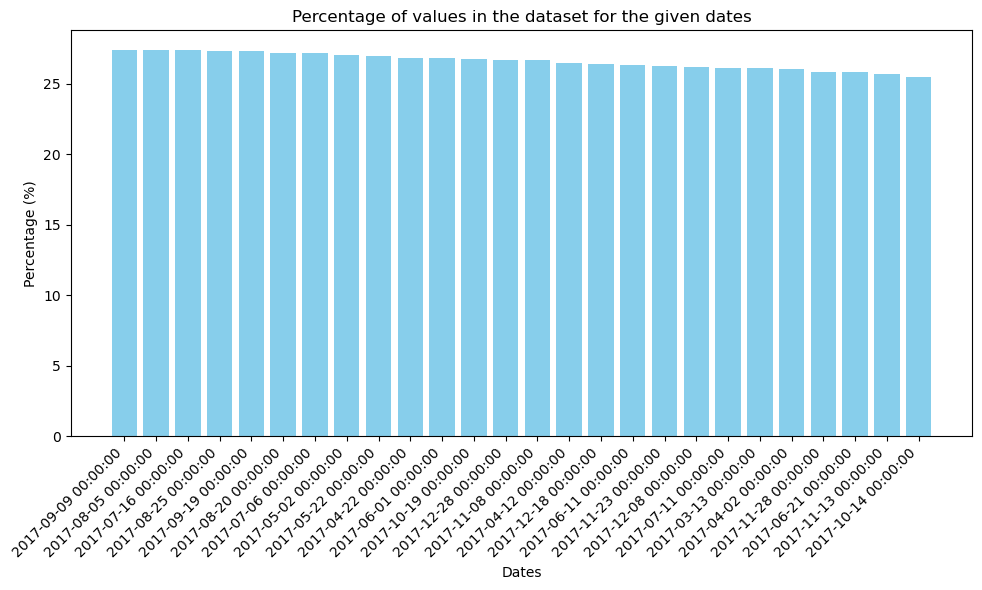

In [9]:
## just for the purpose of showing the output and visualization, we will plot the percent of each timestamp

percent = [round((pair[1]/115755)*100,3) for pair in date_index_numbers]
# Print the percentage of values and corresponding dates
print("The percentage of values in the dataset for the following dates is 0:")
for i in range(len(date_index)):
    print(f"{dates[date_index[i]]}: {percent[i]}%")

plt.figure(figsize=(10, 6))
plt.bar(range(len(date_index)), percent, color='skyblue')
plt.xlabel('Dates')
plt.ylabel('Percentage (%)')
plt.title('Percentage of values in the dataset for the given dates')
plt.xticks(range(len(date_index)), [dates[index] for index in date_index], rotation=45, ha='right')
plt.tight_layout()
plt.show()

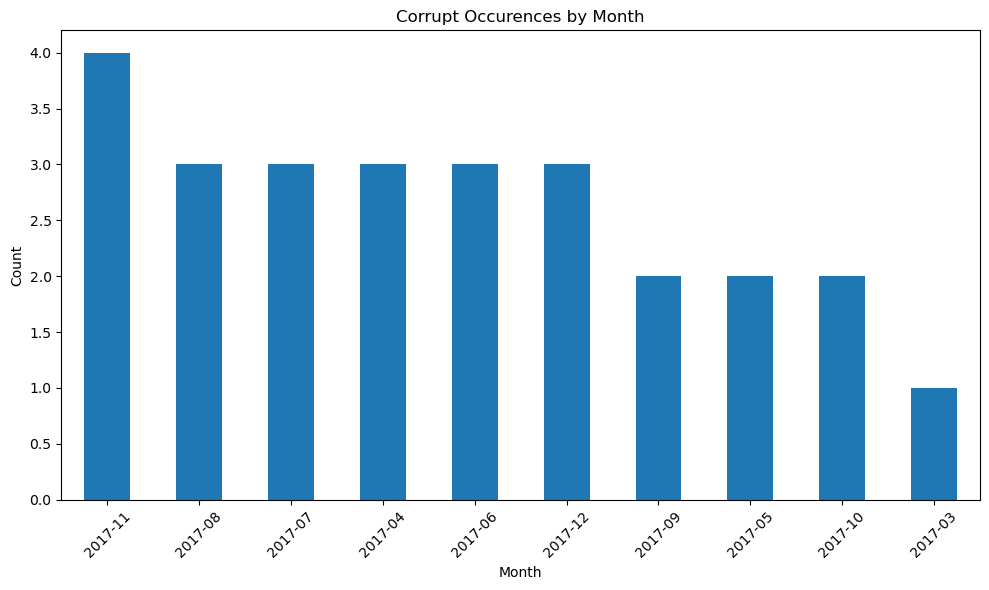

In [10]:
dates_index = pd.Series(dates[date_index])

dates_index = pd.to_datetime(dates_index)
dates_index_month = dates_index.dt.to_period('M')

index_month_counts = dates_index_month.value_counts()

# Plotting the count of occurrences for each month
plt.figure(figsize=(10, 6))
index_month_counts.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Corrupt Occurences by Month')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

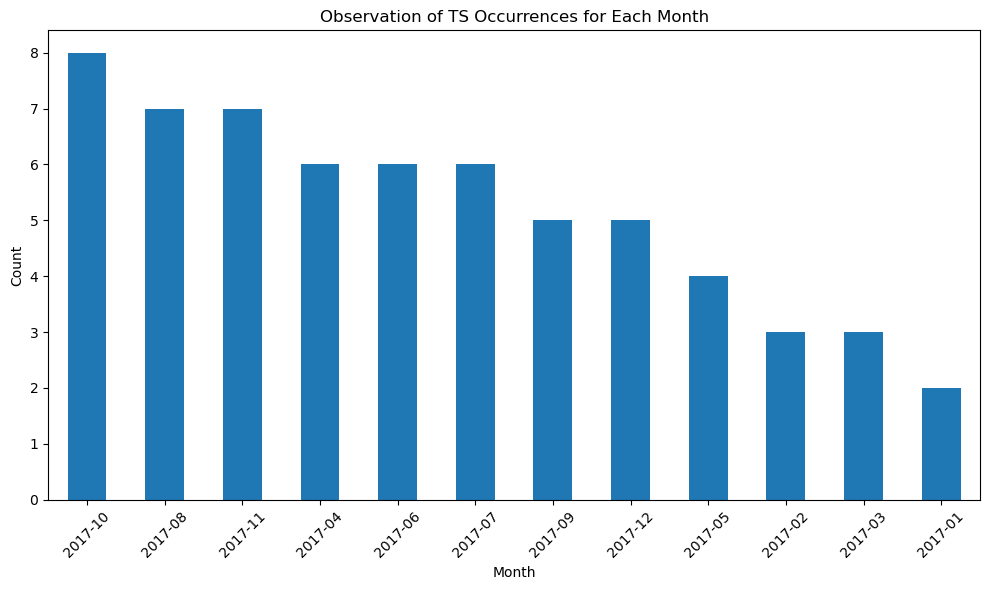

In [11]:
# this is to see how many observations are taking each month - it might not be relevant in this particular
# case study but come in handy for distinct season based analysis

dates_series = pd.Series(dates)

dates_series = pd.to_datetime(dates_series)
dates_series_month = dates_series.dt.to_period('M')

month_counts = dates_series_month.value_counts()

# Plotting the count of occurrences for each month
plt.figure(figsize=(10, 6))
month_counts.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Observation of TS Occurrences for Each Month')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [12]:

# Create an array of indices along the date axis
date_indices = np.arange(series.shape[1])

# Find the indices to keep (those not in indices_to_drop)
indices_to_keep = np.setdiff1d(date_indices, date_index)

# Drop the specified indices along the date axis
data_filtered = series[:, indices_to_keep, :]
dates_filtered = dates[indices_to_keep]

# Display the filtered data
# print(data_filtered)
print(len(data_filtered))
print(len(dates_filtered))
print(np.unique(dates_filtered))


115755
36
[datetime.datetime(2017, 1, 19, 0, 0) datetime.datetime(2017, 1, 29, 0, 0)
 datetime.datetime(2017, 2, 8, 0, 0) datetime.datetime(2017, 2, 18, 0, 0)
 datetime.datetime(2017, 2, 28, 0, 0) datetime.datetime(2017, 3, 10, 0, 0)
 datetime.datetime(2017, 3, 30, 0, 0) datetime.datetime(2017, 4, 9, 0, 0)
 datetime.datetime(2017, 4, 19, 0, 0) datetime.datetime(2017, 4, 29, 0, 0)
 datetime.datetime(2017, 5, 9, 0, 0) datetime.datetime(2017, 5, 19, 0, 0)
 datetime.datetime(2017, 6, 8, 0, 0) datetime.datetime(2017, 6, 18, 0, 0)
 datetime.datetime(2017, 6, 28, 0, 0) datetime.datetime(2017, 7, 3, 0, 0)
 datetime.datetime(2017, 7, 13, 0, 0) datetime.datetime(2017, 7, 18, 0, 0)
 datetime.datetime(2017, 8, 2, 0, 0) datetime.datetime(2017, 8, 7, 0, 0)
 datetime.datetime(2017, 8, 22, 0, 0) datetime.datetime(2017, 8, 27, 0, 0)
 datetime.datetime(2017, 9, 1, 0, 0) datetime.datetime(2017, 9, 11, 0, 0)
 datetime.datetime(2017, 9, 16, 0, 0) datetime.datetime(2017, 10, 6, 0, 0)
 datetime.datetime(2017

### Class distribution
After we cleaned the corrupt dates, it is now time to filter classes. 

This is one of the preliminary EDA step to check the distribution of the `y` set or the target variable. 
As we have learned a little more about our data and completed some pre-processing steps. It is now time to go a step further with data exploration step. 
Now, we will check the class distribution in the time series data. The number of samples/time series observations belong to each class and what are their respective shares in the whole dataset.

This dataset has a class imbalance, as you would see as well. In this case, we are dropping all the classes that have less than 100 sample points + the unknown class. 


In [13]:
# we start with getting the unique ys and their counts

unique, counts = np.unique(labels, return_counts=True)
print(unique)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[19088   462 52537   390    41   277    10     1     3    32  1270  9510
  4083   435    79  3809    51  2687 20990]


In [14]:
class_dict = {} # this dictionary will store the class-names with the corresponding labels
for i in range(len(unique)):
  class_dict[int(unique[i])] = class_names[int(unique[i])]
class_names = list(class_dict.values())
class_dict

{0: 'corn',
 1: 'horsebeans',
 2: 'meadow',
 3: 'spring_barley',
 4: 'spring_oat',
 5: 'spring_peas',
 6: 'spring_rapeseed',
 7: 'spring_rye',
 8: 'spring_triticale',
 9: 'spring_wheat',
 10: 'sunflowers',
 11: 'unknown',
 12: 'winter_barley',
 13: 'winter_oat',
 14: 'winter_peas',
 15: 'winter_rapeseed',
 16: 'winter_rye',
 17: 'winter_triticale',
 18: 'winter_wheat'}

In [15]:
# make a function to get class prop distribution

def UD_class_distribution(y, sorted_by_count = False):
    unique, counts = np.unique(y, return_counts=True)
    percentages = np.array([round((i/sum(counts))*100,3) for i in counts])
    distribution = list(zip(unique, counts, percentages))
    if sorted_by_count:
        distribution = sorted(distribution, key=lambda x: x[1], reverse=True)
    return np.array(distribution)

In [16]:
class_dist= UD_class_distribution(labels, sorted_by_count=True)
class_dist

array([[2.0000e+00, 5.2537e+04, 4.5386e+01],
       [1.8000e+01, 2.0990e+04, 1.8133e+01],
       [0.0000e+00, 1.9088e+04, 1.6490e+01],
       [1.1000e+01, 9.5100e+03, 8.2160e+00],
       [1.2000e+01, 4.0830e+03, 3.5270e+00],
       [1.5000e+01, 3.8090e+03, 3.2910e+00],
       [1.7000e+01, 2.6870e+03, 2.3210e+00],
       [1.0000e+01, 1.2700e+03, 1.0970e+00],
       [1.0000e+00, 4.6200e+02, 3.9900e-01],
       [1.3000e+01, 4.3500e+02, 3.7600e-01],
       [3.0000e+00, 3.9000e+02, 3.3700e-01],
       [5.0000e+00, 2.7700e+02, 2.3900e-01],
       [1.4000e+01, 7.9000e+01, 6.8000e-02],
       [1.6000e+01, 5.1000e+01, 4.4000e-02],
       [4.0000e+00, 4.1000e+01, 3.5000e-02],
       [9.0000e+00, 3.2000e+01, 2.8000e-02],
       [6.0000e+00, 1.0000e+01, 9.0000e-03],
       [8.0000e+00, 3.0000e+00, 3.0000e-03],
       [7.0000e+00, 1.0000e+00, 1.0000e-03]])

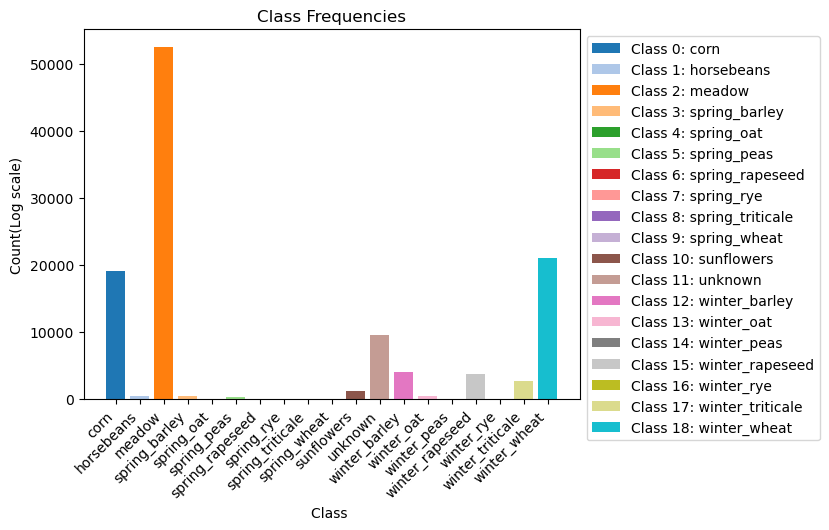

<Figure size 640x480 with 0 Axes>

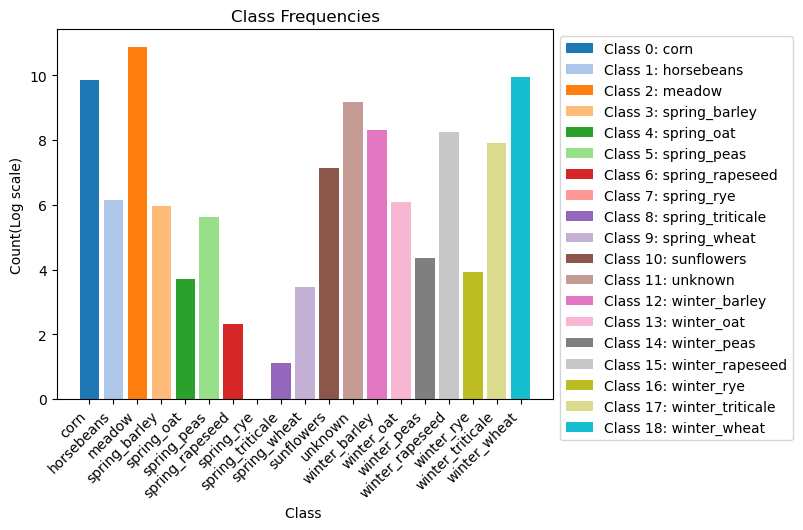

<Figure size 640x480 with 0 Axes>

In [17]:
classFrequency(labels,'tab20',class_names,scale=False)

plt.tight_layout()
plt.show()

# with log scale for better visualization
classFrequency(labels,'tab20',class_names,scale=True)
plt.tight_layout()
plt.show()


## Class Imbalance

It is important to see the classes with only 1, 3 and 10 samples, or generally classes with lower than 100 or 200 samples is discouraging to apply a deep learning model. Firstly, it will be splitted into train_test_val and depending on the percentage of distribution there would be a very small number in the training set to learn any pattern from it. Conversely, there is a chance that all the 10 or 20 samples go into the training set and you get nothing in the validation. 

To remedy that

1- Drop all the minority classes with less than 100 samples + the unknown class (Suggested by the prof. It is noise and mix of different classes)




In [18]:
# identify the class number or label that has <100 samples in the dataset

low_sample_classes_dist = class_dist[np.where(class_dist[:,1]<100)]
print("Classes with very low samples: ", low_sample_classes_dist[:,0].astype(int))
print("Their combined number of samples", np.sum(low_sample_classes_dist[:,1]))
print("\nSince the combined number of samples is also not significant, we will drop them from the dataset.")

Classes with very low samples:  [14 16  4  9  6  8  7]
Their combined number of samples 217.0

Since the combined number of samples is also not significant, we will drop them from the dataset.


In [19]:
# create a filter to drop classes with low samples

filter_condition = np.all([labels != i for i in low_sample_classes_dist[:,0]], axis=0)
# filter another condition to drop class 11

print("\nShape of X and y before dropping: ", data_filtered.shape, labels.shape)
X, y = data_filtered[filter_condition], labels[filter_condition]
print("Shape of X and y after dropping low samples: ", X.shape, y.shape)
filter_condition_2 = np.where(y != 11)[0]
print(filter_condition_2)
X, y = X[filter_condition_2], y[filter_condition_2]
print("Shape of X and y after dropping the unknown as well: ", X.shape, y.shape)


Shape of X and y before dropping:  (115755, 36, 10) (115755,)
Shape of X and y after dropping low samples:  (115538, 36, 10) (115538,)
[     0      2      3 ... 115533 115534 115537]
Shape of X and y after dropping the unknown as well:  (106028, 36, 10) (106028,)


In [20]:
print("Unique labels after dropping the low_sample_classes and unknown class:", np.unique(y))
print(len(np.unique(y)))


Unique labels after dropping the low_sample_classes and unknown class: [ 0  1  2  3  5 10 12 13 15 17 18]
11


In [21]:

# Mapping dictionary
label_mapping = {0: 0, 1: 1, 2: 2, 3: 3,5: 4, 10: 5, 12: 6, 13: 7, 15: 8, 17: 9, 18:10}

# Remap labels using the mapping dictionary
remapped_labels = [label_mapping[label] for label in y]
remapped_labels = np.array(remapped_labels)

# Reverse the label mapping dictionary to create a mapping from new labels to original class names
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Remap class names using the reverse mapping dictionary
remapped_class_names = [class_names[reverse_label_mapping[label]] for label in range(11)]
class_names = remapped_class_names
print(class_names)
print(len(class_names))

['corn', 'horsebeans', 'meadow', 'spring_barley', 'spring_peas', 'sunflowers', 'winter_barley', 'winter_oat', 'winter_rapeseed', 'winter_triticale', 'winter_wheat']
11


In [22]:
y = remapped_labels

print(X.shape, y.shape)

(106028, 36, 10) (106028,)


# Section-2

## Analysis on the proprecessed data

In the preceding cells, we have completed a thorugh pre-processing of the data. We dropped the 26 dates that contained 0 values, which were either cloud shadows and/or noise (different kind). In addition, the class imbalance was addressed in the pre-processing steps, where we dropped the minor classess, as they only aggregate to a 217 samples combined. Besides, we dropped the unknown class from the dataset.

Now, we have clean dataset prepared and ready for further processing and analysis. 


In [23]:

# Compute statistics for each feature

min_per_feature = np.min(X, axis=(0, 1))
max_per_feature = np.max(X, axis=(0, 1))
percentiles_per_feature = np.percentile(X, q=[2, 50, 98], axis=(0, 1))

# Create DataFrame for statistics
df_stats = pd.DataFrame({
    'Minimum': min_per_feature,
    'Maximum': max_per_feature,
    '2 Percentile': percentiles_per_feature[0],
    'Median': percentiles_per_feature[1],
    '98th Percentile': percentiles_per_feature[2]
})

# Print statistics table
print(df_stats)


   Minimum  Maximum  2 Percentile  Median  98th Percentile
0   602.06 17016.15        886.70 1424.77          7801.42
1   429.65 17105.99        747.67 1328.55          7422.04
2   253.98 19230.59        440.98 1299.16          7933.18
3   269.68 20224.18       1231.88 3329.61          8504.27
4   266.90 19574.53        685.23 1613.68          8137.54
5   342.15 20065.96       1156.04 2866.77          8400.45
6   321.07 20713.22       1305.96 3413.79          8653.68
7   241.67 21079.45       1368.99 3730.70          8764.64
8    64.66 11329.92        696.15 2319.78          5879.80
9    39.03  9456.70        371.42 1476.88          4677.84


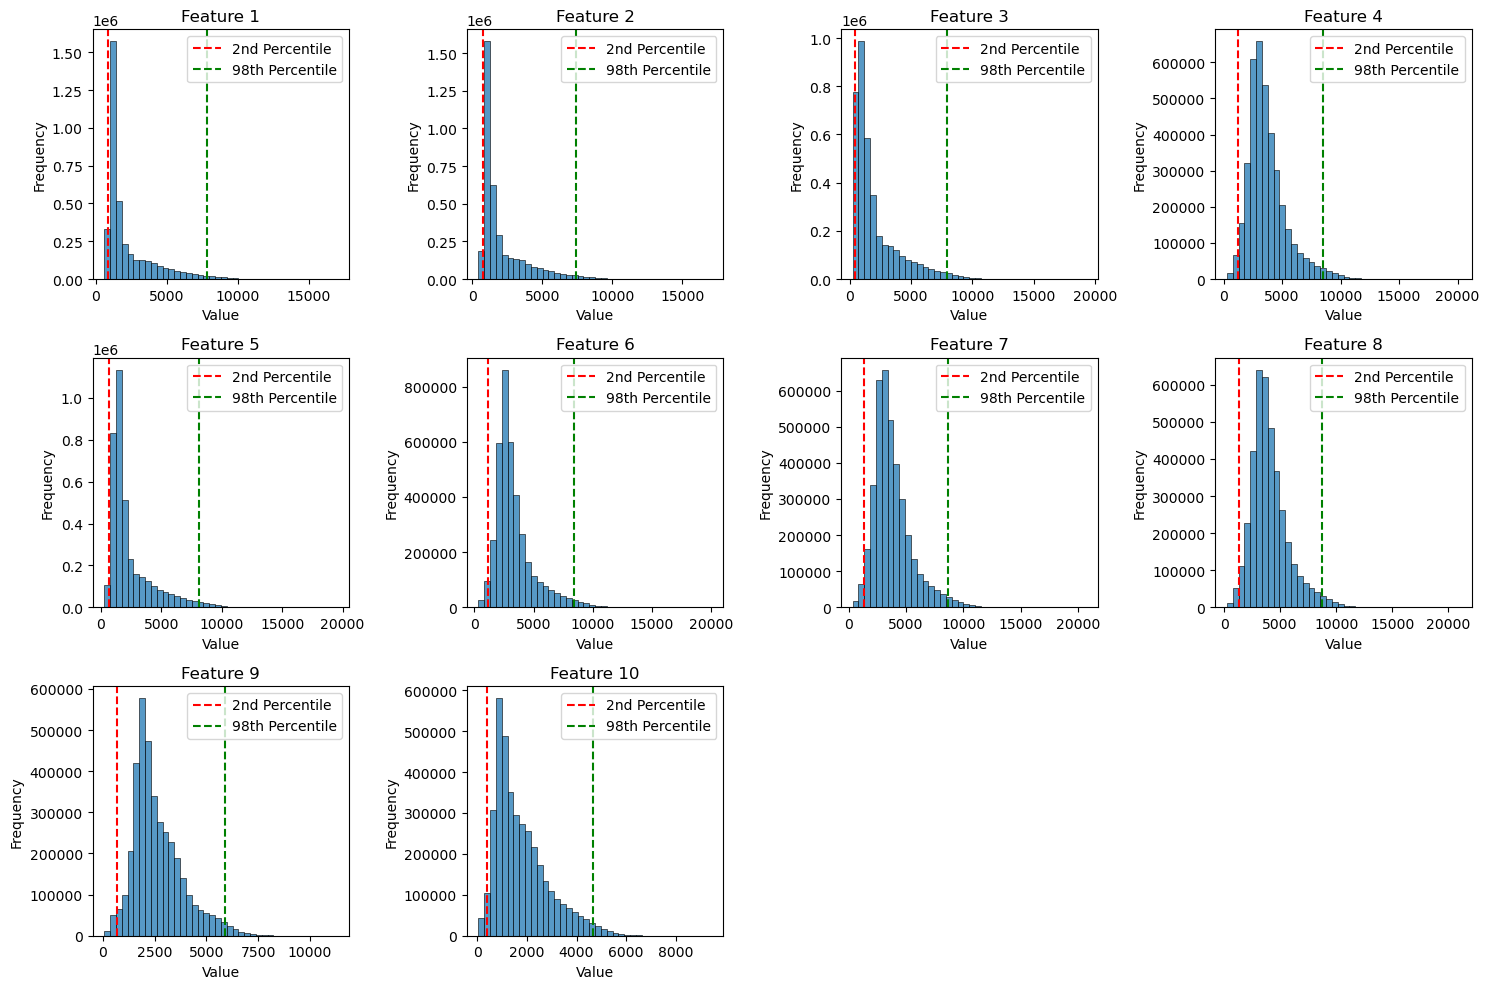

In [24]:

# Plot bar plots for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(df_stats.index):
    plt.subplot(3, 4, i+1)
    sns.histplot(X[:, :, i].flatten(), bins=40, kde=False)
    plt.axvline(x=percentiles_per_feature[0][i], color='r', linestyle='--', label='2nd Percentile')
    plt.axvline(x=percentiles_per_feature[2][i], color='g', linestyle='--', label='98th Percentile')
    plt.title(f'Feature {feature+1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

[[[ 7.45933042e-02  5.67472618e-02  6.92248672e-02 ...  1.77017002e-01
    2.26166289e-01  1.81767292e-01]
  [ 1.34859691e-01  1.17975247e-01  1.30653981e-01 ...  1.51073681e-01
    2.39626530e-01  2.77511917e-01]
  [ 4.92107272e-01  4.84787891e-01  5.25885503e-01 ...  5.96379629e-01
    7.93303203e-01  8.13326564e-01]
  ...
  [ 4.08132629e-02  3.77622814e-02  3.89669290e-02 ...  2.26487418e-01
    2.27394158e-01  1.37301880e-01]
  [ 5.27064750e-02  4.16464547e-02  4.95141317e-02 ...  2.06538272e-01
    1.95255690e-01  1.13840188e-01]
  [ 4.21344245e-01  3.87140188e-01  3.93944734e-01 ...  3.72338532e-01
    4.24500077e-01  3.68979506e-01]]

 [[ 6.10483971e-02  5.11483340e-02  3.55494960e-02 ...  3.36461954e-01
    1.89070529e-01  1.07743886e-01]
  [ 4.64613506e-02  5.22902798e-02  3.53537829e-02 ...  3.63015170e-01
    2.42074987e-01  1.28871514e-01]
  [ 2.41158268e-02 -6.64642571e-04  5.59732938e-04 ... -8.40458758e-04
   -4.42828278e-02 -3.40169660e-02]
  ...
  [ 8.53264218e-02  6.1

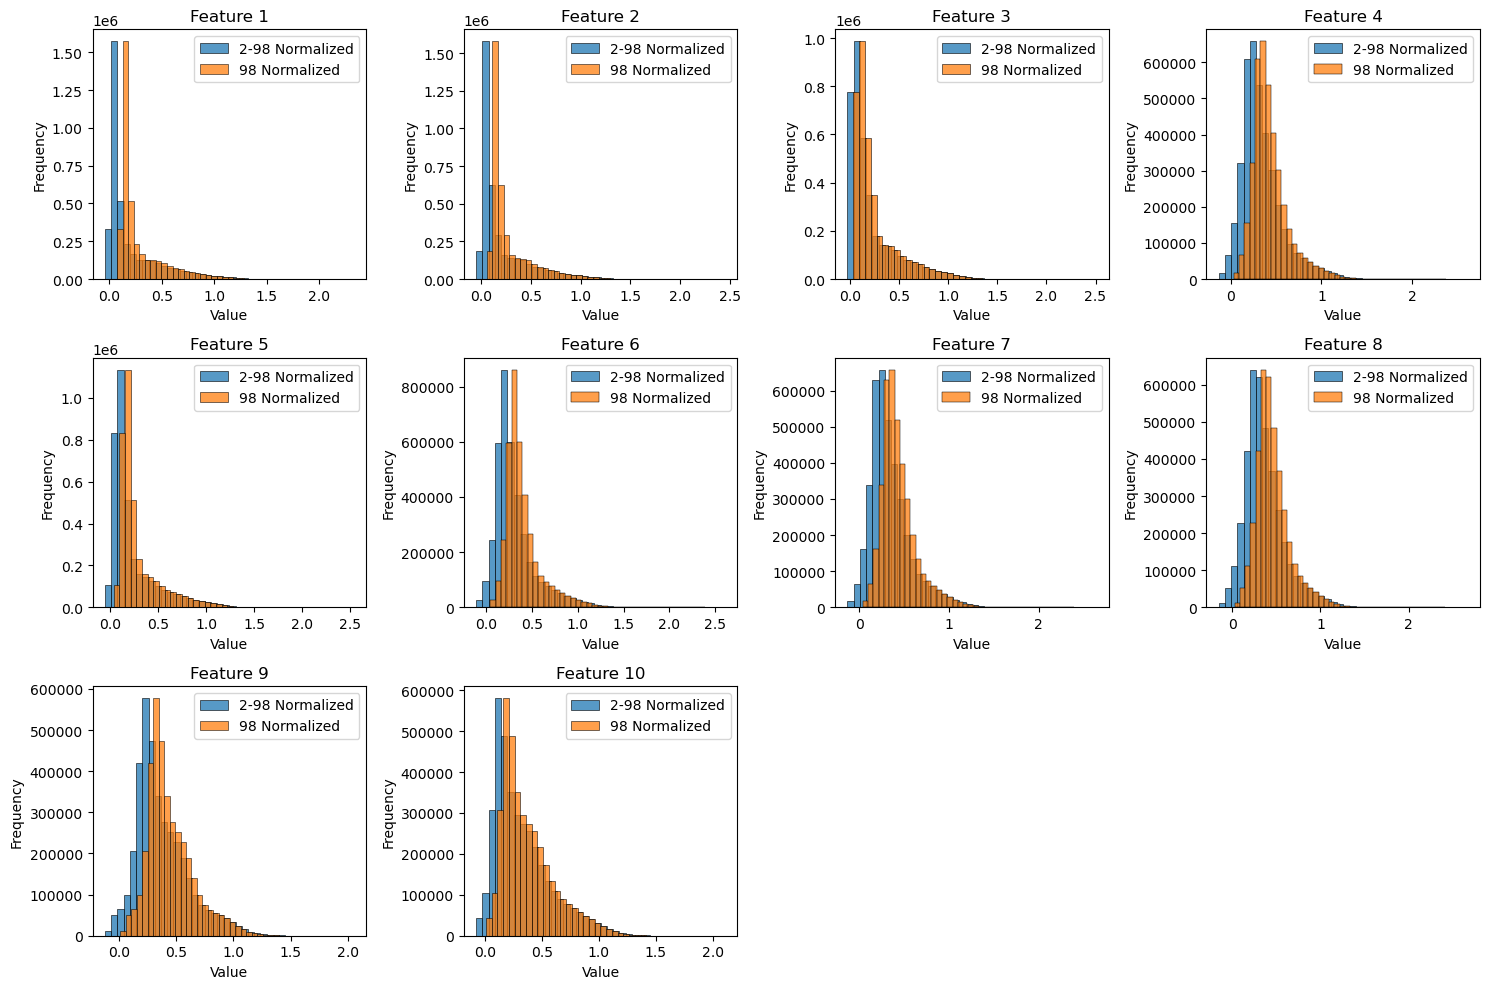

In [25]:
# if 2nd and 98th percentile are available, we can use them to normalize the data otherwise if only 98th percentile is available, we can use it to normalize the data

def normalize(X, perc_2, perc_98):
    if perc_2 is not None:
        X_normalized = (X - perc_2) / (perc_98 - perc_2)
    else:
        X_normalized = X / perc_98
    return X_normalized
perc_2 = percentiles_per_feature[0]
perc_98 = percentiles_per_feature[2]
# Normalize the data
X_normalized_98 = normalize(X, None, perc_98)
X_normalized_2_98 = normalize(X, perc_2, perc_98)
print(X_normalized_2_98)
print(X_normalized_98)

# Plot the normalized data for each feature
plt.figure(figsize=(15, 10))
for i in range(X.shape[2]):
    plt.subplot(3, 4, i+1)
    sns.histplot(X_normalized_2_98[:, :, i].flatten(), bins=40, kde=False)
    sns.histplot(X_normalized_98[:, :, i].flatten(), bins=40, kde=False)
    plt.title(f'Feature {i+1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(['2-98 Normalized', '98 Normalized'])
plt.tight_layout()
plt.show()

In [32]:
# # combine class_names, X, y and dates_filtered into a npz file and save it
# np.savez_compressed('Fr1_98_p_norm_data.npz', series=X_normalized_2_98, labels=y, dates=dates_filtered, class_names=class_names)
# np.savez_compressed('AT_98_p_norm_data.npz', series=X_normalized_98, labels=y, dates=dates_filtered, class_names=class_names)

## NDVI profiling for each class

In many agriculture related problems, the vegetation index is given more importance as the fundamental distinction for crops/any vegetated field from the rest of the assets. 

In the following section, we try to estimate the AVG - NDVI for each class label/sample (as each sample `[l, d]` correspond to a label). 
 

In [26]:
# estimating NDVI - NIR and Red Band (Band 8 and Band 4 respectively for Sentinel-2)

# B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12' these are 10 bands used as 10 features in this dataset

# first with the normazlied data with 2nd and 98th percentile

# band_4_n1 = X_normalized_2_98[:,:,3] 
# band_8_n1 = X_normalized_2_98[:,:,7]

band_4_n2 = X_normalized_98[:,:,3]
band_8_n2 = X_normalized_98[:,:,7]

smoothing = 0.001 # smoothing factor to address the 0/0 situation

# ndvi_n1 = band_8_n1-band_4_n1/band_8_n1+band_4_n1+smoothing
ndvi_n2 = band_8_n2-band_4_n2/band_8_n2+band_4_n2+smoothing


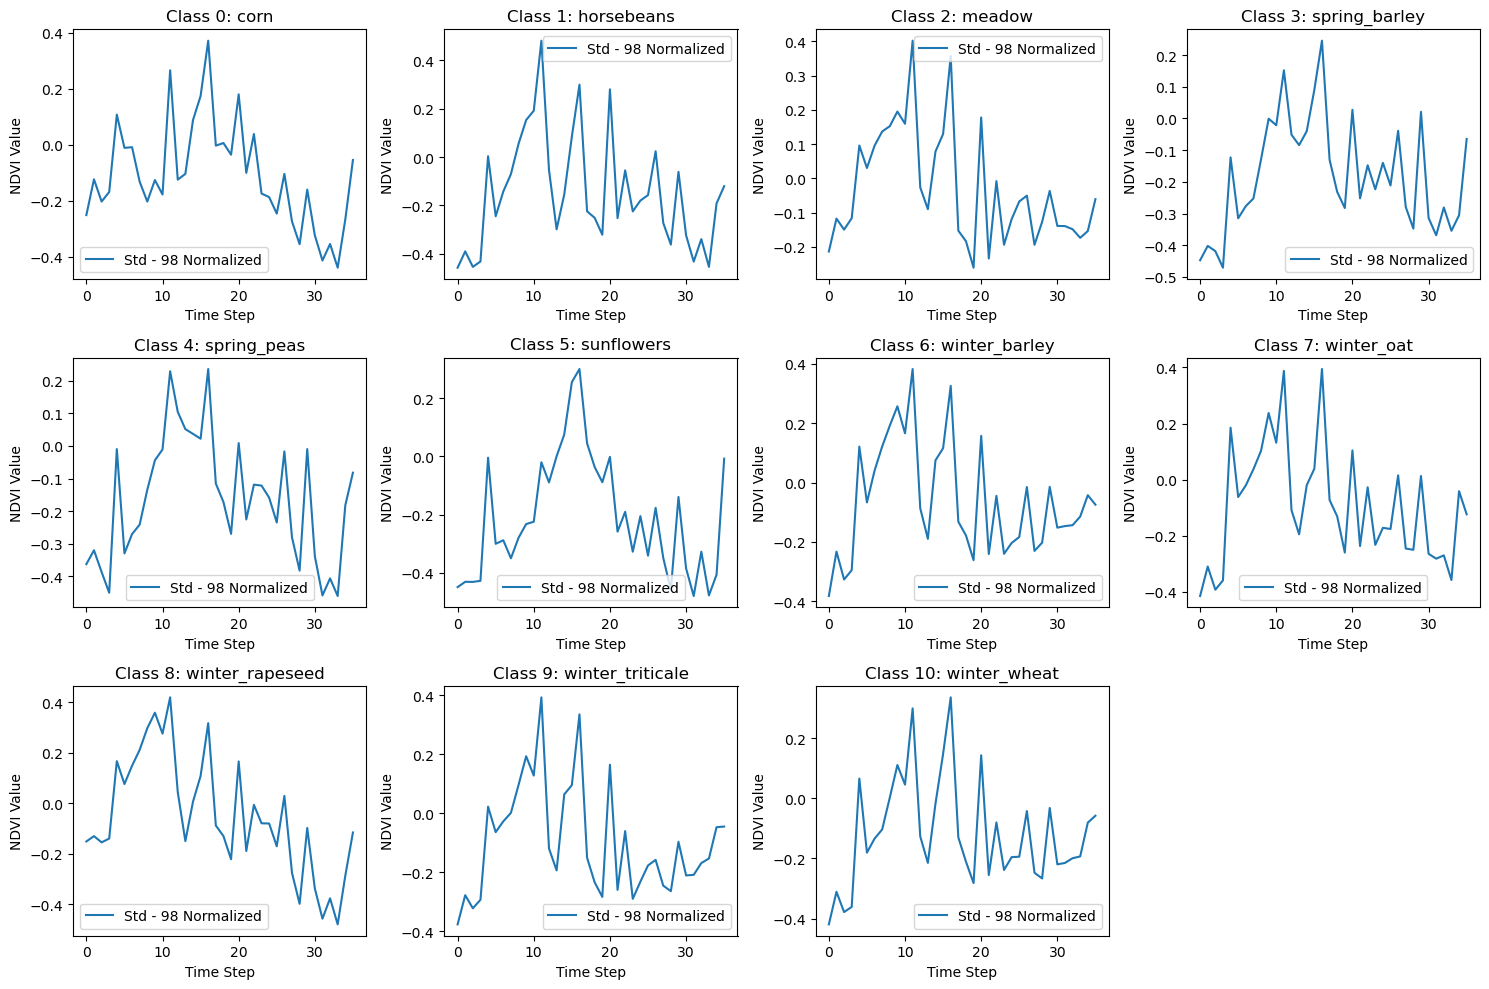

In [27]:
# estimating mean NDVI for each class for each date
unique = np.unique(y)
ndvi_mean = np.zeros((len(unique), X.shape[1]))
ndvi_per = np.zeros((len(unique), X.shape[1]))
ndvi_std = np.zeros((len(unique), X.shape[1]))
for i in range(len(np.unique(y))):
  ndvi_mean[i] = np.median(ndvi_n2[y == unique[i]], axis=0)
  ndvi_std[i] = np.median(ndvi_n2[y == unique[i]], axis=0)
  ndvi_per[i] = np.percentile(ndvi_n2[y == unique[i]], 90, axis=0)

ndvi_mean.shape
ndvi_per.shape
ndvi_std.shape

# plot the ndvi_std for each class
plt.figure(figsize=(15, 10))
for i in range(len(unique)):
    plt.subplot(3, 4, i+1)
    #plt.plot(ndvi_mean[i])
    #plt.plot(ndvi_per[i])
    plt.plot(ndvi_std[i])
    plt.title(f'Class {unique[i]}: {class_names[i]}')
    plt.xlabel('Time Step')
    plt.ylabel('NDVI Value')
    plt.legend(['Std - 98 Normalized']) 
plt.tight_layout()
plt.show()




# Band Profiling

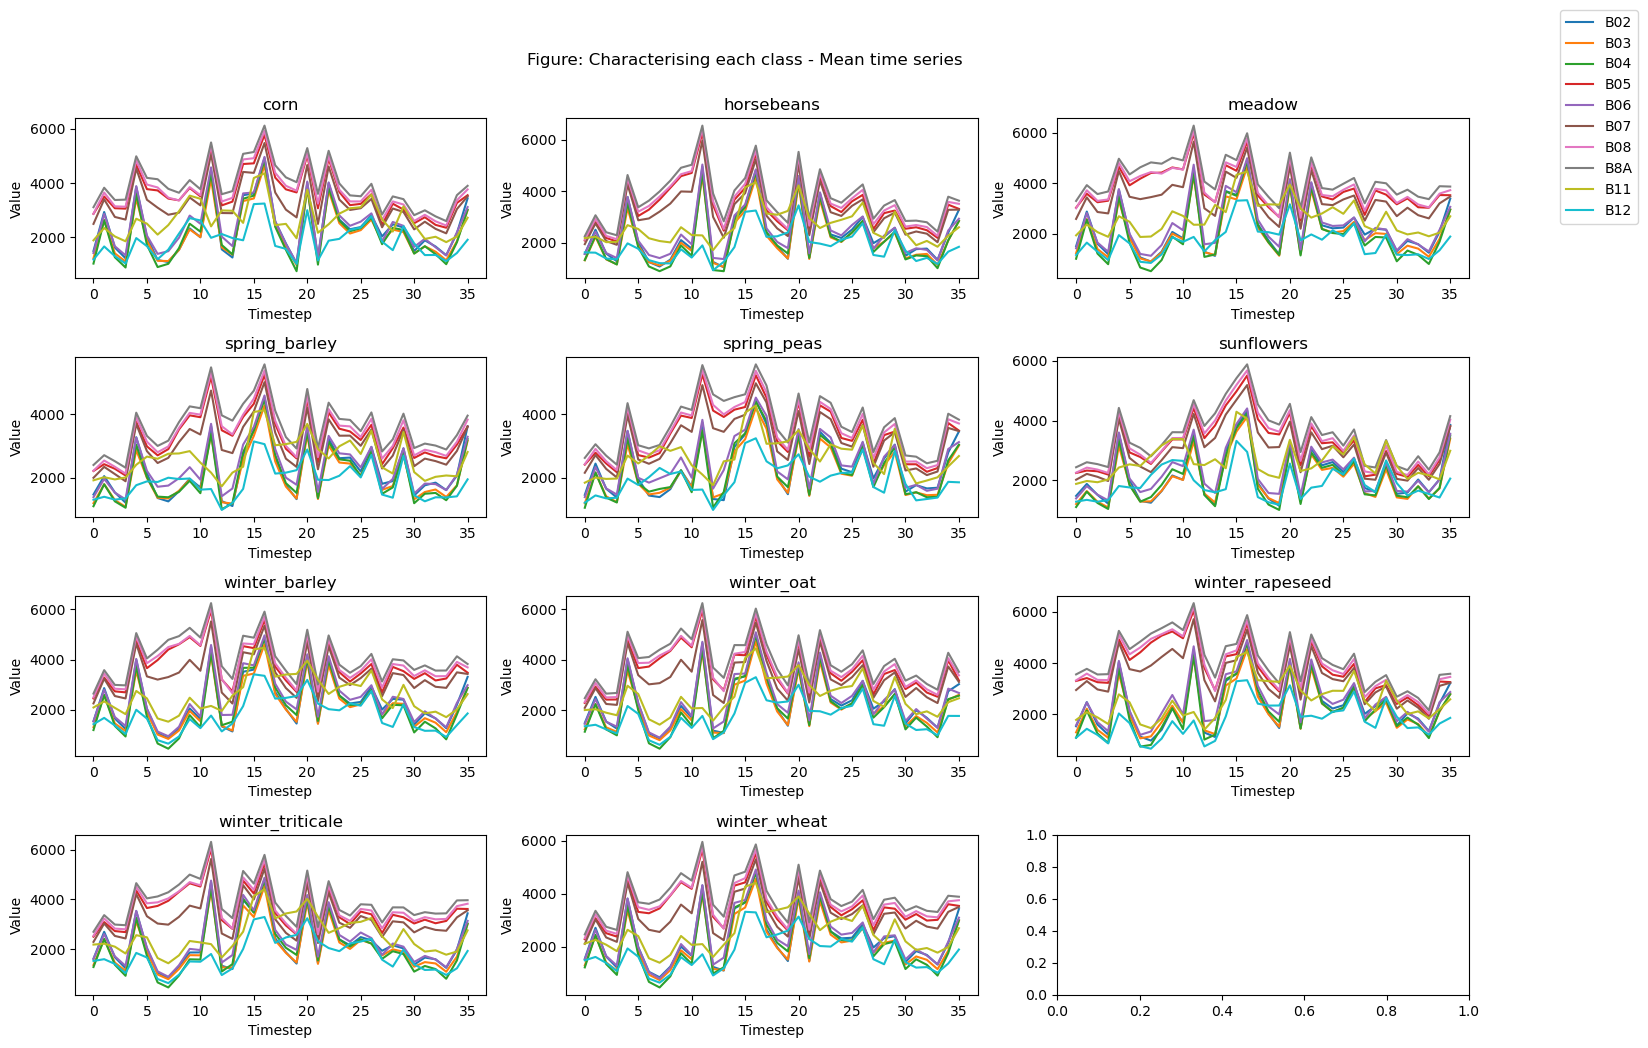

In [28]:
# NDVI is a good estimate when it is about veg; however, it is also imp to understand the trends for all the other bands in the dataset
# again mean values across all the unique classes

X_mean = np.zeros((len(unique), X.shape[1], X.shape[2]))
for i in range(len(np.unique(y))):
  X_mean[i] = np.mean(X[y == unique[i]], axis=0)
X_mean.shape

fig, axs = plt.subplots(4, 3, figsize=(15, 10))
axs = axs.ravel()
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
for i in range(len(unique)):
  # add band number as legend
  for j in range(X_mean.shape[2]):
    axs[i].plot(X_mean[i, :, j], label=bands[j])
  axs[i].set_title(class_names[i])
  axs[i].set_xlabel('Timestep')
  axs[i].set_ylabel('Value')
fig.legend(bands, loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.suptitle('Figure: Characterising each class - Mean time series', fontsize=12,x=0.5, y=1)
plt.tight_layout()
plt.show()

## Optional Part - Tried to make covariances for the time series data

In [1]:
# load libraries

import warnings
warnings.filterwarnings("ignore")

# for data processing

import os
import numpy as np
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import joblib
from textwrap import dedent
import time
from tqdm import tqdm
import json

# custom module to make data frequency viz

from class_frequency import classFrequency

# important performance metrics

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import euclidean_distances
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    ConfusionMatrixDisplay,)


# pyreimann

import pyriemann
from scipy.linalg import eigvalsh, solve
from pyriemann.utils.distance import distance_euclid, distance_riemann, distance_logeuclid, distance_logdet, distance_kullback, distance_wasserstein
from pyriemann.utils.mean import mean_riemann, mean_logeuclid, mean_euclid, mean_wasserstein, mean_ale
from pyriemann.utils.base import logm, sqrtm, invsqrtm
from pyriemann.utils.covariance import covariances
from pyriemann.classification import KNearestNeighbor

# sktime

from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.base.adapters._tslearn import _TslearnAdapter
from sktime.classification.base import BaseClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifierTslearn
from sktime.dists_kernels.dtw import DtwDist
from sktime.transformations.panel.rocket import Rocket


In [2]:
main_path = r"C:\Users\Khizer Zakir\OneDrive - Université Bretagne Sud\thesis\Covariance_Thesis\notebooks\npz_data_preprocessed"
data_path = os.path.join(main_path, "DK_98_p_norm_data.npz")

In [3]:
# Data loading

data = np.load(data_path, allow_pickle= True)
series = data['series'] # time series (m,l,b)
labels = data['labels'] 
# dates = data['dates'] # acquisition dates (datetime package)
class_names = data['class_names'] # names of the class
data.close()

In [33]:
X = series
y = labels

In [48]:
# transpose X_normalized_98 from (sample, length, channels) to (sample, channels, length)
X_cov = X.transpose(0, 2, 1)

In [49]:
cov_matrix = covariances(X_cov, estimator='scm')
cov_matrix.shape

(53823, 10, 10)

In [50]:
X[y==2][0].mean(axis=1
                ).shape

(28,)

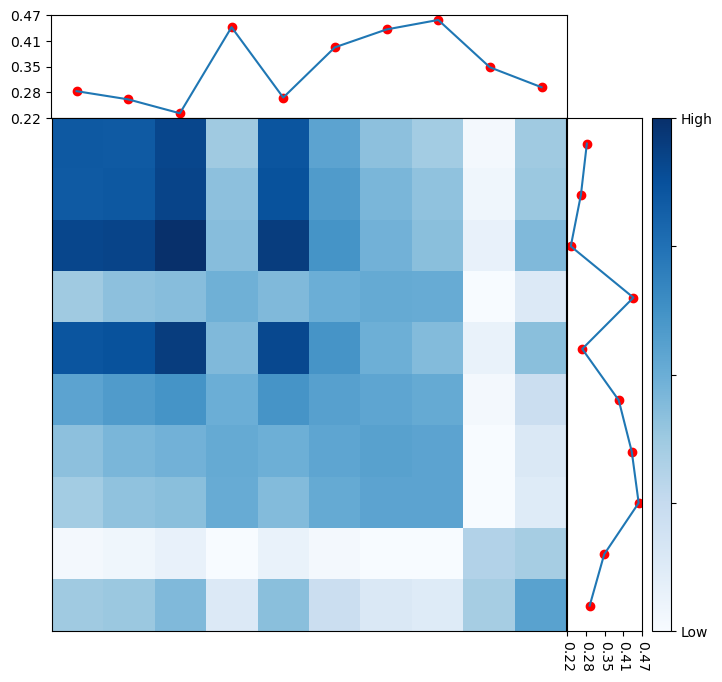

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the figure and the gridspec layout
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], wspace=0, hspace=0)

# Plot the top time series
ax0 = fig.add_subplot(gs[0, 0])
time_series_top = X[y == 2][0].mean(axis=0)
ax0.plot(time_series_top)
ax0.scatter(range(len(time_series_top)), time_series_top, color='red')
ax0.set_xticks(range(10))
ax0.set_xticklabels(range(10), rotation=90)
ax0.set_yticks(np.linspace(ax0.get_ylim()[0], ax0.get_ylim()[1], 5))
ax0.set_yticklabels(np.round(np.linspace(ax0.get_ylim()[0], ax0.get_ylim()[1], 5), 2))

# Plot the main matrix
ax1 = fig.add_subplot(gs[1, 0])
cax = ax1.matshow(cov_matrix[y == 2][0], cmap='Blues')

# Remove ticks from the covariance matrix plot
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the side time series
ax2 = fig.add_subplot(gs[1, 1], sharey=ax1)
time_series_side = X[y == 2][0].mean(axis=0)
ax2.plot(time_series_side, np.arange(10))
ax2.scatter(time_series_side, np.arange(10), color='red')
ax2.set_xticks(np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], 5))
ax2.set_xticklabels(np.round(np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], 5), 2), rotation=270)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

## Adjust the limits to ensure alignment
ax1.set_ylim(ax2.get_ylim())
ax0.set_xlim(ax1.get_xlim())

# Create a new axis for the color bar
divider = make_axes_locatable(ax2)
cax_cb = divider.append_axes("right", size="25%", pad=0.1)

# Add a color bar outside the plot
cbar = fig.colorbar(cax, cax=cax_cb)
cbar.set_ticks(np.linspace(np.min(cov_matrix[y == 2][0]), np.max(cov_matrix[y == 2][0]), 5))
cbar.ax.set_yticklabels(['Low', '', '', '', 'High'])

plt.show()

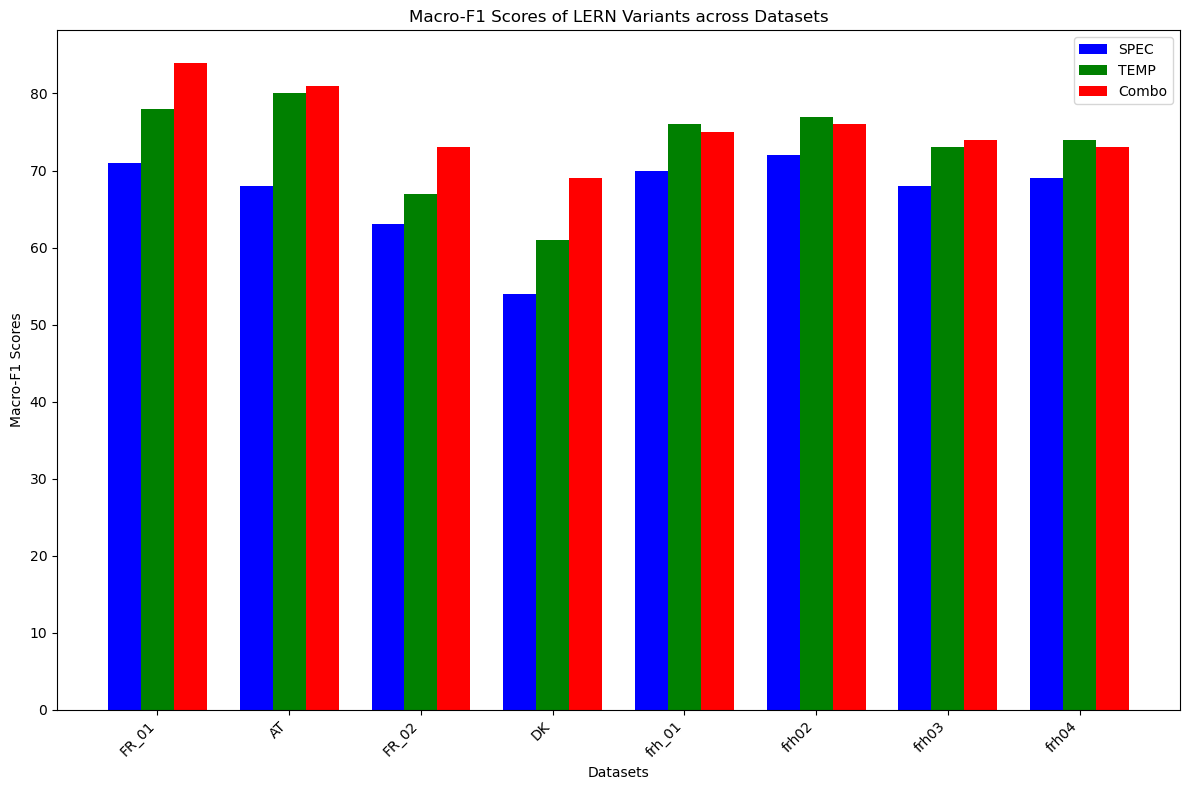

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Data
datasets = ['FR_01', 'AT', 'FR_02', 'DK', 'frh_01', 'frh02', 'frh03', 'frh04']
spec_macro_f1 = [71, 68, 63, 54, 70, 72, 68, 69]
temp_macro_f1 = [78, 80, 67, 61, 76, 77, 73, 74]
combo_macro_f1 = [84, 81, 73, 69,75, 76, 74, 73]

# Calculate the position for bars on x-axis
x = np.arange(len(datasets))
bar_width = 0.25  # Width of the bars

# Position adjustment for each group
bar_spec = x - bar_width
bar_temp = x
bar_combo = x + bar_width

# Plot
plt.figure(figsize=(12, 8))

# Plot bars for each variant
plt.bar(bar_spec, spec_macro_f1, width=bar_width, label='SPEC', color='b', align='center')
plt.bar(bar_temp, temp_macro_f1, width=bar_width, label='TEMP', color='g', align='center')
plt.bar(bar_combo, combo_macro_f1, width=bar_width, label='Combo', color='r', align='center')

# X-axis labels and ticks
plt.xlabel('Datasets')
plt.ylabel('Macro-F1 Scores')
plt.title('Macro-F1 Scores of LERN Variants across Datasets')
plt.xticks(x, datasets, rotation=45, ha='right')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


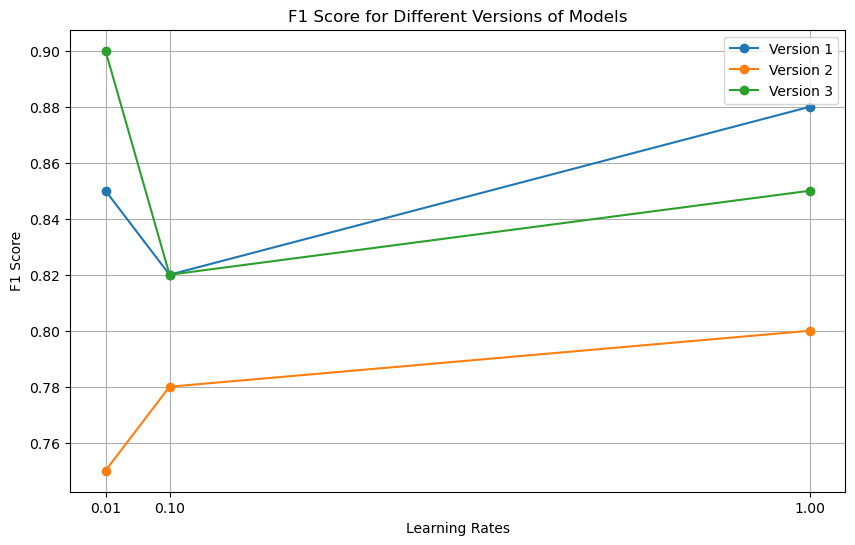

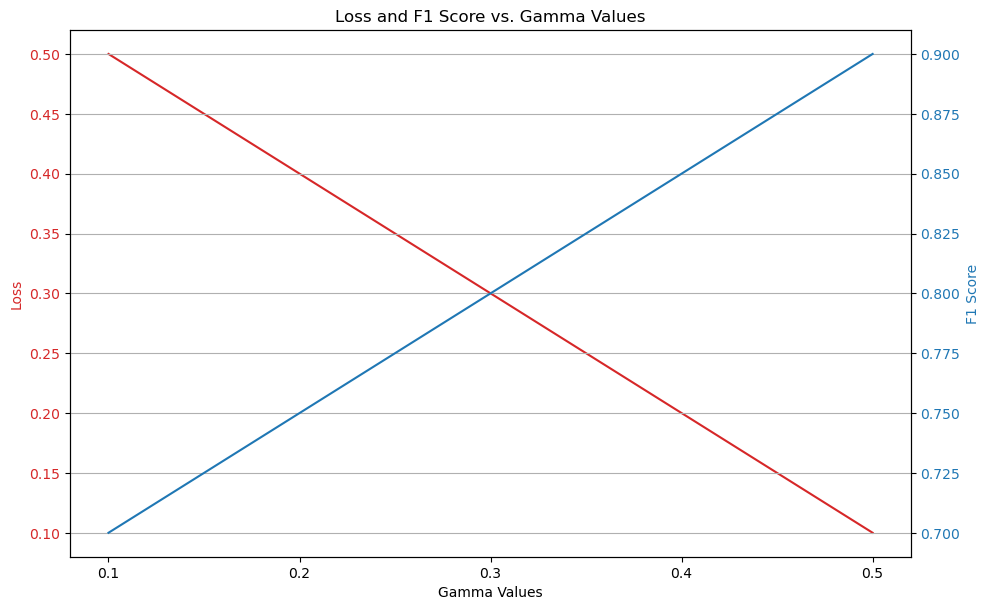

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Learning rates and corresponding F1 scores
learning_rates = [0.01, 0.1, 1.0]
version1_f1 = [0.85, 0.82, 0.88]
version2_f1 = [0.75, 0.78, 0.80]
version3_f1 = [0.90, 0.82, 0.85]

# Create line graph with points for different versions of models
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, version1_f1, marker='o', label='Version 1')
plt.plot(learning_rates, version2_f1, marker='o', label='Version 2')
plt.plot(learning_rates, version3_f1, marker='o', label='Version 3')

plt.xlabel('Learning Rates')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Versions of Models')
plt.xticks(learning_rates)
plt.legend()
plt.grid(True)
plt.show()

# Gamma values and corresponding loss and F1 scores
gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5]
loss_values = [0.5, 0.4, 0.3, 0.2, 0.1]
f1_scores = [0.7, 0.75, 0.8, 0.85, 0.9]

# Create a dual y-axis graph for loss and F1 score
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Gamma Values')
ax1.set_ylabel('Loss', color=color)
ax1.plot(gamma_values, loss_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('F1 Score', color=color)  
ax2.plot(gamma_values, f1_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Loss and F1 Score vs. Gamma Values')
plt.xticks(gamma_values)
plt.grid(True)
plt.show()


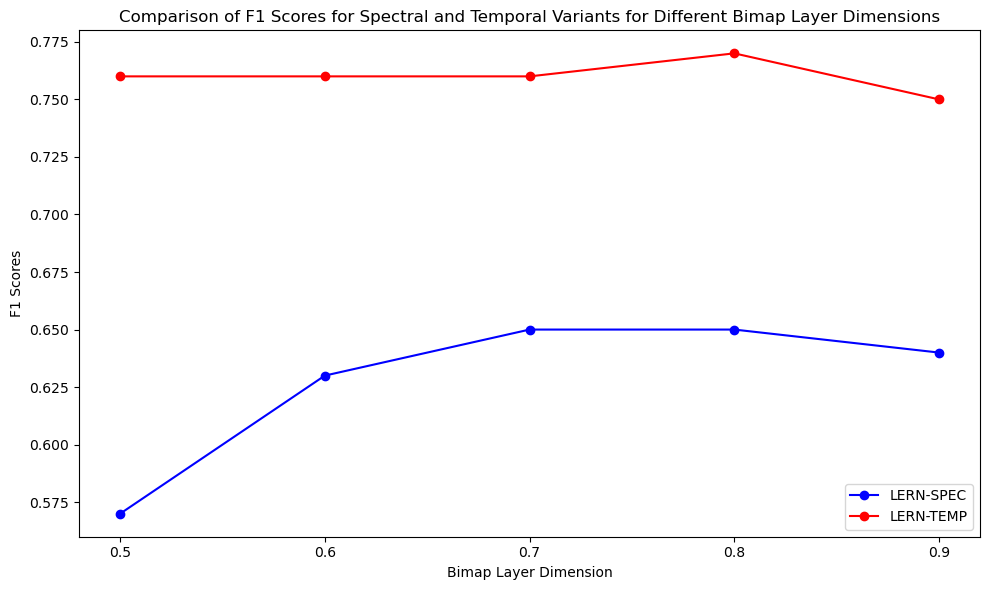

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data
bimap_dims = [0.5, 0.6, 0.7, 0.8, 0.9]
lern_spec_scores = [0.57, 0.63, 0.65, 0.65, 0.64]
lern_temp_scores = [0.76, 0.76, 0.76, 0.77, 0.75]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(bimap_dims, lern_spec_scores, marker='o', color='b', label='LERN-SPEC')
plt.plot(bimap_dims, lern_temp_scores, marker='o', color='r', label='LERN-TEMP')

plt.xlabel('Bimap Layer Dimension')
plt.ylabel('F1 Scores')
plt.title('Comparison of F1 Scores for Spectral and Temporal Variants for Different Bimap Layer Dimensions')
plt.legend()

# Explicitly set the ticks and labels
plt.xticks(bimap_dims)

# Clean background
plt.gca().set_facecolor('white')
plt.grid(visible=False)

plt.tight_layout()
plt.show()


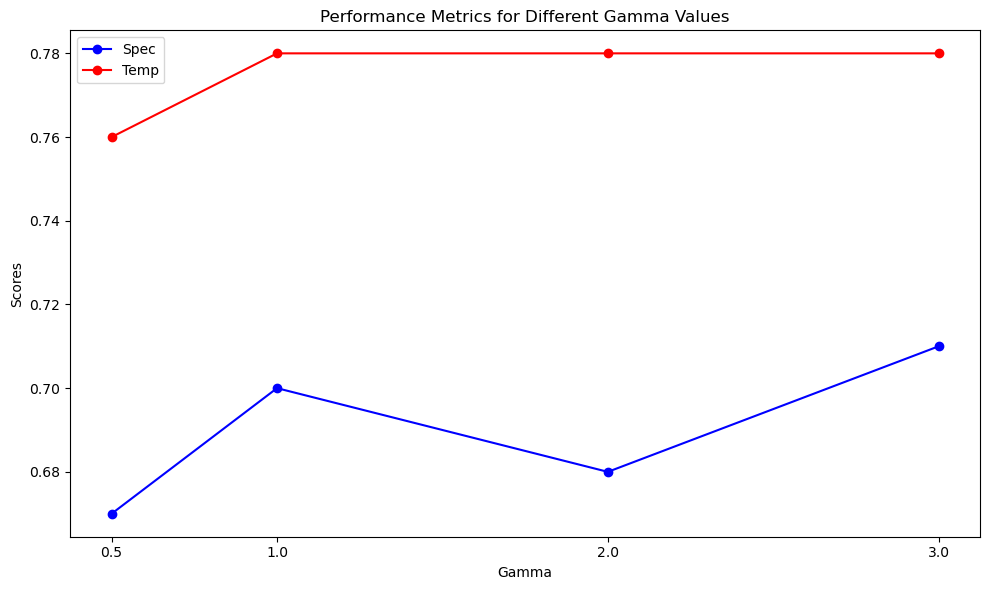

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Data
gamma = [2, 3, 1, 0.5]
spec_scores = [0.68, 0.71, 0.70, 0.67]
temp_scores = [0.78, 0.78, 0.78, 0.76]

# Sort gamma values and corresponding scores
sorted_indices = np.argsort(gamma)
gamma = np.array(gamma)[sorted_indices]
spec_scores = np.array(spec_scores)[sorted_indices]
temp_scores = np.array(temp_scores)[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))

# Plot lines for Spec and Temp scores
plt.plot(gamma, spec_scores, marker='o', color='b', label='Spec')
plt.plot(gamma, temp_scores, marker='o', color='r', label='Temp')

# X-axis labels and ticks
plt.xlabel('Gamma')
plt.ylabel('Scores')
plt.title('Performance Metrics for Different Gamma Values')
plt.xticks(gamma)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
